# Ising Model Neural Nets
Here, I develop two neural nets which are trained to classify simulation results of the Ising model into "low" and "high" temperature phases. In addition to correctly classifying the configurations, I show that the output of the neural nets can be used to determine the critical phase transition temperature. 

The nets are first trained and validated on data from a square lattice Ising model. Then, the model is tested on a dataset of simulations of the Ising model on a triangular lattice. During training, the nets are only provided the simulation configurations and the label "low" or "high"; the temperature value used for each configuration is not used provided to the nets.

I first train a neural net with a single hidden layer. Then, I train a deep convolutional net.

The results presented here are primarily a reproduction of the the findings in a recent Nature Physics publication:
[Link to paper][example].

  [example]: https://www.nature.com/articles/nphys4035

In [1]:
%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

# Load Data

Set the paths of training, validation, and test sets.

In [2]:
train_path = '../../data/Ising/train/'
test_path = '../../data/Ising/test/'
valid_path = '../../data/Ising/valid/'

Set up some helper functions to load and label the data.

The file name for each simulation is in the form ```phase_Temp_index_.npy``` where ```phase``` is either "high" or "low" and is the label we are training with. We also keep track of the temperature of each simulations, which will allow us to determine the critical phase transition temperature. ```index``` simply provides a unique file name to each configuration.

In [85]:
def one_hot_label(img):
    # img is the file name of a configuration
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,T
def data_with_label(data_path,*args):
    data = []
    if args: # The args are a list if directories in the data path that separate the classes/categories
        for category in args:
            for i in tqdm(os.listdir(data_path + category)):
                path = os.path.join(data_path, category,i)
                img = np.load(path)
                data.append([img, one_hot_label(i)])
        shuffle(data)
        return data

Load in the train and validation sets.

Each element of the sets consists of a tuple of the form: (numpy array, one hot label, temperature)

In [14]:
train_set=data_with_label(train_path,'low','high')
valid_set=data_with_label(valid_path,'low','high')

100%|██████████| 1600/1600 [00:00<00:00, 3938.56it/s]


Separate the loaded data into arrays containing the image data, label data, and temperature data.

In [57]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])

Take a look at a few samples.

The low temperature configurations tend to be predominately aligned in either the "up" (yellow) or "down" (purple) directions. This is expected since aligned spins is a lower energy state. For the high temperature configurations, clusters of aligned spins form.  

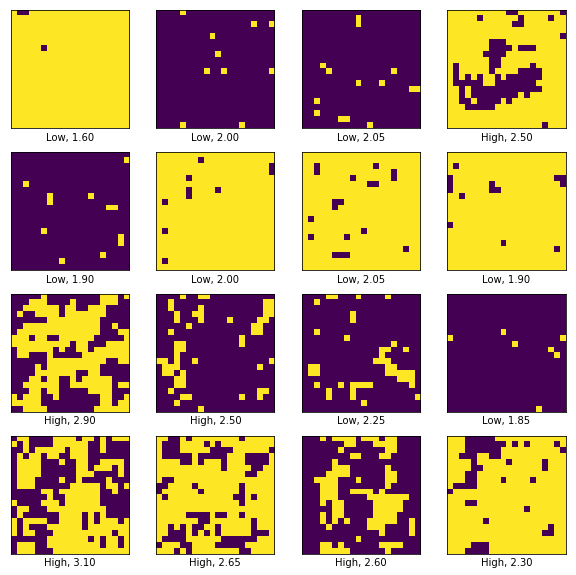

In [16]:
plt.figure(figsize=(10,10))
for i in range(16):
    #idx=bad_predictions[i]
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_img_data[i])
    if tr_lbl_data[i][0] == 1:
        label = "Low"
    elif tr_lbl_data[i][1] == 1:
        label = "High"
    plt.xlabel(f'{label}, {tr_Temp_data[i]}')

## Single hidden layer NN
First, I create a simple neural net with a single 100-unit hidden layer with ReLU activation. The output layer contains two units with a softmax activation.

Define the model with the tf.Keras sequential API.

In [81]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Set the model optimizer, learning rate, and loss function.

In [82]:
model1.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Train the model!

In [83]:
model1.fit(x=tr_img_data,y=tr_lbl_data, epochs=10,batch_size=64)

Epoch 1/10
15000/15000 [==============================] - 1s 83us/step - loss: 0.1941 - acc: 0.9241
Epoch 2/10
15000/15000 [==============================] - 1s 57us/step - loss: 0.1409 - acc: 0.9465
Epoch 3/10
15000/15000 [==============================] - 1s 51us/step - loss: 0.1245 - acc: 0.9518
Epoch 4/10
15000/15000 [==============================] - 1s 53us/step - loss: 0.1073 - acc: 0.9582
Epoch 5/10
15000/15000 [==============================] - 1s 53us/step - loss: 0.0978 - acc: 0.9617
Epoch 6/10
15000/15000 [==============================] - 1s 54us/step - loss: 0.0861 - acc: 0.9679
Epoch 7/10
15000/15000 [==============================] - 1s 52us/step - loss: 0.0730 - acc: 0.9711
Epoch 8/10
15000/15000 [==============================] - 1s 55us/step - loss: 0.0663 - acc: 0.9748
Epoch 9/10
15000/15000 [==============================] - 1s 52us/step - loss: 0.0571 - acc: 0.9793
Epoch 10/10
15000/15000 [==============================] - 1s 51us/step - loss: 0.0485 - acc: 0.9833

Evaluate the model performance on the validation set.

In [84]:
val_loss, val_acc = model1.evaluate(val_img_data, val_lbl_data,)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

3000/3000 [==============================] - 0s 132us/step
Validation accuracy: 0.9343333334922791
Validation loss: 0.21049466670428713


## Determine the critical temperature
Now that the model is trained, I can use the prediction output on the validation set to determine the critical temperature. 

First get the model predictions for the validation set, and separate the outputs for the two neurons in the final layer.

In [76]:
predictions=model1.predict(val_img_data)

low_predict = predictions[:,0]
high_predict = predictions[:,1]

Now combine the temperature of the simulations with their predicted phase.

In [77]:
df1 = pd.DataFrame({'low_prediction':low_predict,'High_prediction':high_predict, 'Temp':val_Temp_data})
df1.head()

,low_prediction,High_prediction,Temp
0,0.999670,0.000330,1.80
1,0.999796,0.000204,1.75
2,0.000001,0.999999,2.95
3,0.999226,0.000774,1.80
4,0.000009,0.999991,2.90


For each temperature, determine the average (and standard deviation) output of both neurons in the output layer. 
Then, plot these averages against the Temperature.

In [78]:
df2=df1.groupby('Temp').mean()
df3=df1.groupby('Temp').std()

This plot shows the average output of the final layer for configurations of different temperatures. The temperature at which the curves cross indicate the temperature at which the neural net, on average, switches between classifying a configuration as a "low" vs "high" temperature phase. This is precicesly the critical temperature. For a square lattice, the critical temperature for the Ising model is ~2.27. The crossing point in the plot is very close to this value.

The model was never given direct information about the temperatures in the dataset, yet it correctly identifies the critical phase transition temperature.

Other properties to note, are that there is very little variation in the model prediction far from the critical temperature, and increase variation near the crossing point. This is expected, given that configurations are very simuilar on either side of the switching point. I can impove this uncertainty by increasing the size of the validation set, only 100 configurations for each temperature are present in the validation set. In the paper, Carrasquilla, 2017, 10,000 configurations are used for each temperature.

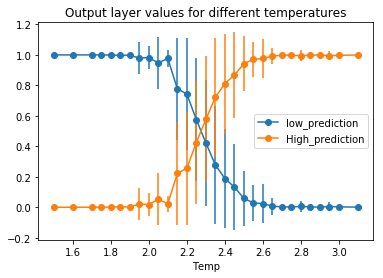

In [105]:
df2.plot(marker='o',yerr=df3, title="Output layer values for different temperatures")

We can take a look at some of the incorrectly classified examples. Below, I plot configurations that were classified as "low" temperature phase, but for which the temperature was >=2.4

Configurations that were strongly classified as "low" tend to have very small clusters. The ones with larger clusters, are only marginally misclassified (i.e. output for the "low"-neuron is ~0.6

In [106]:
bad_predictions=[]
for i in range(len(val_lbl_data)):
    if (low_predict[i]>0.5 and val_Temp_data[i]>=2.4):
        bad_predictions.append(i)

In [107]:
#bad_predictions
#idx=bad_predictions[1]
#plt.imshow(val_img_data[idx])
#print(val_lbl_data[idx],val_Temp_data[idx],low_predict[idx])

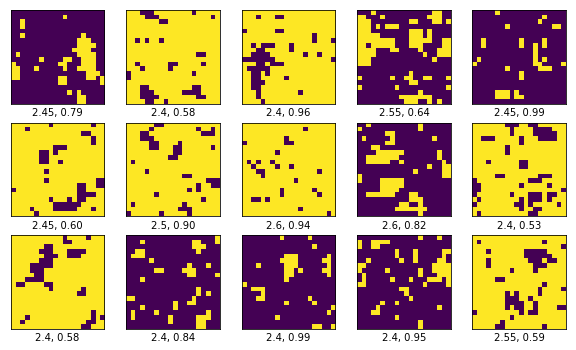

In [110]:
# Plot incorrectly classified examples, and show the temperature and output of the "low" prediction neuron.
plt.figure(figsize=(10,10))
for i in range(15):
    idx=bad_predictions[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_img_data[idx])
    plt.xlabel(f'{val_Temp_data[idx]}, {low_predict[idx]:.2f}')

## Convolutional Neural Net
Now I construct a neural net with two hidden layers. One is a 2-D convolutional layer with 64 filters, and another is a fully connected layer.

First I reshape the input data to feed into the convolutional layer.

In [111]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)
val_img_data = np.array([i[0] for i in valid_set]).reshape(-1,20,20,1)

Define the CNN.

In [114]:
model2 = keras.Sequential([
    #keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Conv2D(64, (2, 2), input_shape=(20, 20, 1), padding='same'),
    keras.layers.ReLU(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [115]:
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Train!

In [116]:
model2.fit(x=tr_img_data,y=tr_lbl_data, epochs=10,batch_size=64)

Epoch 1/10
15000/15000 [==============================] - 2s 161us/step - loss: 0.2112 - acc: 0.9291
Epoch 2/10
15000/15000 [==============================] - 2s 113us/step - loss: 0.1508 - acc: 0.9497
Epoch 3/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.1302 - acc: 0.9575
Epoch 4/10
15000/15000 [==============================] - 2s 101us/step - loss: 0.1164 - acc: 0.9614
Epoch 5/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.1063 - acc: 0.9638
Epoch 6/10
15000/15000 [==============================] - 2s 109us/step - loss: 0.0943 - acc: 0.9678
Epoch 7/10
15000/15000 [==============================] - 2s 108us/step - loss: 0.0805 - acc: 0.9717
Epoch 8/10
15000/15000 [==============================] - 2s 104us/step - loss: 0.0725 - acc: 0.9757
Epoch 9/10
15000/15000 [==============================] - 1s 100us/step - loss: 0.0672 - acc: 0.9782
Epoch 10/10
15000/15000 [==============================] - 2s 102us/step - loss: 0.0639 - a

In [118]:
val_loss, val_acc = model2.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)
print('Validation loss:', val_loss)

3000/3000 [==============================] - 0s 103us/step
Test accuracy: 0.9336666666666666
Validation loss: 0.242769040892832


We achieve similar performance to the single-hidden-layer net above.

In [119]:
predictions2=model2.predict(val_img_data)

low_predict2 = predictions2[:,0]
high_predict2 = predictions2[:,1]

In [133]:
df4 = pd.DataFrame({'low_prediction':low_predict2,'high_prediction':high_predict2, 'Temp':val_Temp_data})


Again, we see that the cross-over temperature is very near the theoretical value (2.27)

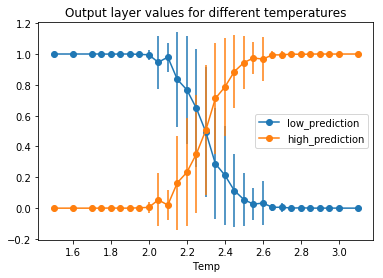

In [134]:
df5=df4.groupby('Temp').mean()
df6=df4.groupby('Temp').std()
df5.plot(marker='o',yerr=df6,title="Output layer values for different temperatures")

## Test model on triangular lattice simulations
To test the predictive power of these neural nets, I use the trained CNN to classify Ising simulations on a triangular lattice. The main difference for a triangular lattice is that the critical phase transition temperature is different from the square lattice. This is because each particle in a triangular lattice has 6 nearest neighbors, as opposed to 4 in a square lattice.

Critical Temperature fro triangular lattice is ~3.65

First load the triangular lattice test data.

In [137]:
testTri_path = '../../data/Ising/testTri/'

In [138]:
testTri_set=data_with_label(testTri_path,'low','high')
testTri_img_data = np.array([i[0] for i in testTri_set])
testTri_lbl_data = np.array([i[1][0] for i in testTri_set])
testTri_Temp_data = np.array([float(i[1][1]) for i in testTri_set])

100%|██████████| 800/800 [00:00<00:00, 3535.11it/s]


In [139]:
testTri_img_data = np.array([i[0] for i in testTri_set]).reshape(-1,20,20,1)

Use the trained CNN above to classify the high and low temperature states.

I achieve similar accuracy as on the validation set.

In [141]:
test_loss, test_acc = model2.evaluate(testTri_img_data, testTri_lbl_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2000/2000 [==============================] - 0s 73us/step
Test accuracy: 0.936
Test loss: 0.23583182990550994


Next, I determine the critical phase transition temperature.

In [142]:
predictions3=model2.predict(testTri_img_data)

low_predict3 = predictions3[:,0]
high_predict3 = predictions3[:,1]

In [143]:
dfT1 = pd.DataFrame({'low_prediction':low_predict3,'high_prediction':high_predict3, 'Temp':testTri_Temp_data})


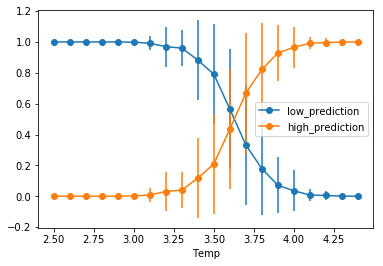

In [144]:
dfT2=dfT1.groupby('Temp').mean()
dfT3=dfT1.groupby('Temp').std()
dfT2.plot(marker='o',yerr=dfT3)

The predicted crossing point is indeed very closs to the theoretical value of 3.65 !

Future work on this topic will be on improving the neural nets, and exploring how changes to the generated datasets (i.e. using a different simulation algorithm) alter the neural net training.